In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/healthcare-dataset-stroke-data.csv')

In [3]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [6]:
data['bmi'].fillna(data['bmi'].median(), inplace=True)

<ipython-input-6-e1e4c94b9983>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['bmi'].fillna(data['bmi'].median(), inplace=True)


In [7]:
data.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


In [8]:
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [9]:
data = pd.get_dummies(data, columns=categorical_cols, drop_first=False)

In [10]:
data.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,False,True,False,...,False,True,False,False,False,True,False,True,False,False
1,51676,61.0,0,0,202.21,28.1,1,True,False,False,...,False,False,True,False,True,False,False,False,True,False
2,31112,80.0,0,1,105.92,32.5,1,False,True,False,...,False,True,False,False,True,False,False,False,True,False
3,60182,49.0,0,0,171.23,34.4,1,True,False,False,...,False,True,False,False,False,True,False,False,False,True
4,1665,79.0,1,0,174.12,24.0,1,True,False,False,...,False,False,True,False,True,False,False,False,True,False


In [11]:
target_column = 'stroke'
feature_columns = data.columns.drop(['stroke']).tolist()

In [13]:
X = data[feature_columns].values
y = data[target_column].values
print("Feature Columns:", feature_columns)
print("Target Column:", target_column)

Feature Columns: ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Female', 'gender_Male', 'gender_Other', 'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']
Target Column: stroke


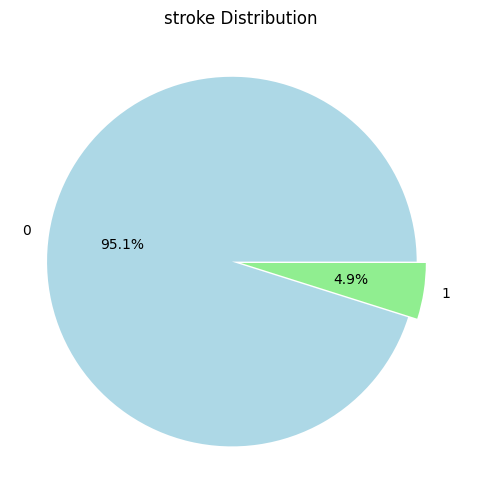

In [15]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
data.stroke.value_counts().plot(kind='pie', autopct='%0.1f%%', colors=['lightblue', 'lightgreen'], explode=(0.05, 0))
plt.title('stroke Distribution')
plt.ylabel('')
plt.show()

In [16]:
# 데이터와 타겟 분리
X = data[feature_columns].values
y = data[target_column].values

In [17]:
# Split the dataset into training and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw) # Use transform only for test set

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4088, 22), (1022, 22), (4088,), (1022,))

In [19]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [20]:
# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4088, 22]),
 torch.Size([1022, 22]),
 torch.Size([4088]),
 torch.Size([1022]))

In [22]:
class strokeDense(nn.Module):
    def __init__(self):
        super(strokeDense, self).__init__()
        self.fc1 = nn.Linear(22, 64)  # input features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # 2 classes (0 or 1) in the dataset

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) # Output raw scores (logits)
        return x

# Initialize the model
dense_model = strokeDense()

In [23]:
# CrossEntropyLoss 사용
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dense_model.parameters(), lr=0.001)

In [26]:
# Variables to store loss and accuracy
dense_train_losses = []
dense_test_accuracies = []
dense_all_labels_list = []
dense_all_predictions_list = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    dense_model.train()
    running_loss = 0.0001
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = dense_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0) # Multiply by batch size

    # Calculate average loss over an epoch
    epoch_loss = running_loss / len(train_dataloader.dataset)
    dense_train_losses.append(epoch_loss)

    # Evaluate on test data
    dense_model.eval()
    correct = 0
    total = 0
    epoch_labels = []
    epoch_predictions = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = dense_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_labels.extend(labels.cpu().numpy())
            epoch_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    dense_test_accuracies.append(accuracy)
    # Store labels/predictions from the *last* epoch for final evaluation
    if epoch == num_epochs - 1:
        dense_all_labels = np.array(epoch_labels)
        dense_all_predictions = np.array(epoch_predictions)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Dense Network Training complete.")

Epoch 1/50, Loss: 0.0812, Accuracy: 94.23%
Epoch 2/50, Loss: 0.0799, Accuracy: 94.03%
Epoch 3/50, Loss: 0.0771, Accuracy: 93.93%
Epoch 4/50, Loss: 0.0771, Accuracy: 94.32%
Epoch 5/50, Loss: 0.0763, Accuracy: 94.52%
Epoch 6/50, Loss: 0.0747, Accuracy: 94.03%
Epoch 7/50, Loss: 0.0734, Accuracy: 94.42%
Epoch 8/50, Loss: 0.0718, Accuracy: 92.86%
Epoch 9/50, Loss: 0.0710, Accuracy: 94.52%
Epoch 10/50, Loss: 0.0711, Accuracy: 94.23%
Epoch 11/50, Loss: 0.0694, Accuracy: 93.74%
Epoch 12/50, Loss: 0.0681, Accuracy: 94.03%
Epoch 13/50, Loss: 0.0680, Accuracy: 93.74%
Epoch 14/50, Loss: 0.0652, Accuracy: 93.35%
Epoch 15/50, Loss: 0.0669, Accuracy: 94.32%
Epoch 16/50, Loss: 0.0640, Accuracy: 94.13%
Epoch 17/50, Loss: 0.0656, Accuracy: 93.44%
Epoch 18/50, Loss: 0.0625, Accuracy: 94.13%
Epoch 19/50, Loss: 0.0622, Accuracy: 93.84%
Epoch 20/50, Loss: 0.0607, Accuracy: 93.25%
Epoch 21/50, Loss: 0.0601, Accuracy: 91.68%
Epoch 22/50, Loss: 0.0607, Accuracy: 94.13%
Epoch 23/50, Loss: 0.0569, Accuracy: 93.5

In [27]:
# Evaluation using metrics from the last epoch
conf_matrix = confusion_matrix(dense_all_labels, dense_all_predictions)
# Use average='weighted' for overall performance, or 'binary' for class 1 focus
f1 = f1_score(dense_all_labels, dense_all_predictions, average='weighted')
precision = precision_score(dense_all_labels, dense_all_predictions, average='weighted')
recall = recall_score(dense_all_labels, dense_all_predictions, average='weighted')

# Calculate specificity (True Negative Rate) for the negative class (0)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Specificity for class 0

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall (Sensitivity): {recall:.2f}') # Recall is also Sensitivity
print(f'Specificity: {specificity:.2f}')

Confusion Matrix:
[[950  22]
 [ 42   8]]
F1 Score: 0.93
Precision: 0.92
Recall (Sensitivity): 0.94
Specificity: 0.98


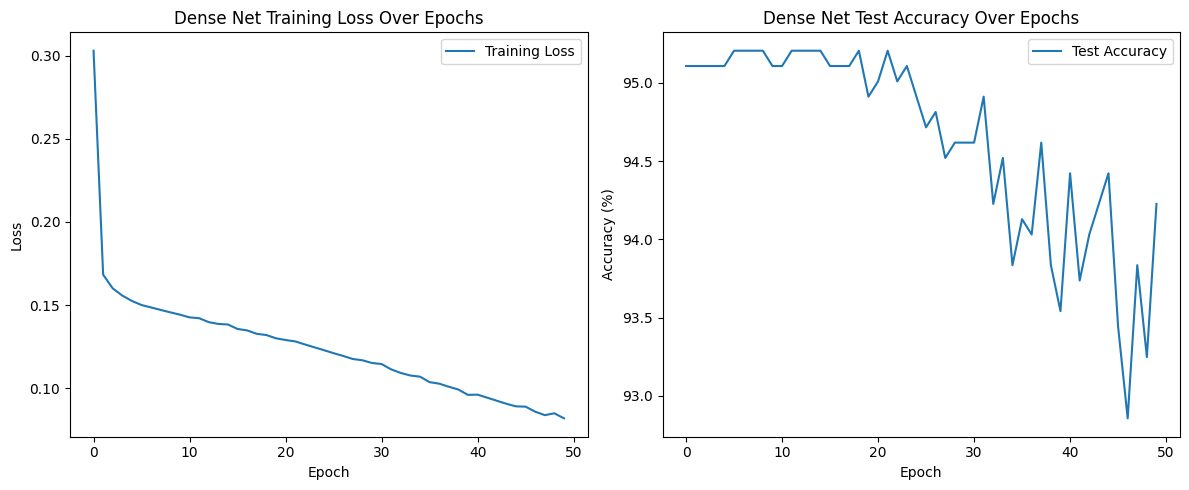

In [25]:
# Plot the loss and accuracy for Dense Network
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(dense_train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Dense Net Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(dense_test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Dense Net Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()